# Section 1: The Preprocessing Pipeline for Tabular Data

## This section explores creating a preprocessing pipeline on a [credit card fraud](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) related dataset.

## Step 1. Exploratory Data Analysis (EDA)
* Plot distributions of Amount and Time.
* Analyze class imbalance (fraud vs. normal).

In [27]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


print('Available Datasets: ', os.listdir("/kaggle/input/"))
CREDIT_DIR = "/kaggle/input/creditcardfraud"

Available Datasets:  ['creditcardfraud', 'chest-xray-pneumonia']


In [28]:
df = pd.read_csv(CREDIT_DIR + '/creditcard.csv')
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

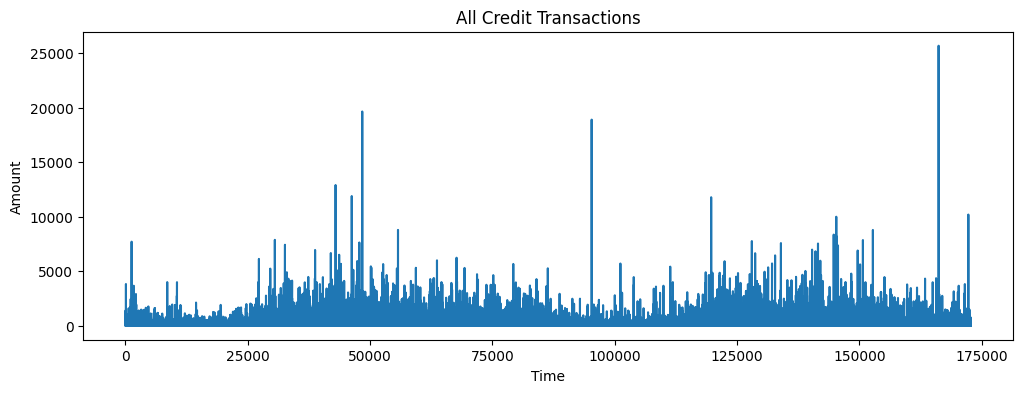

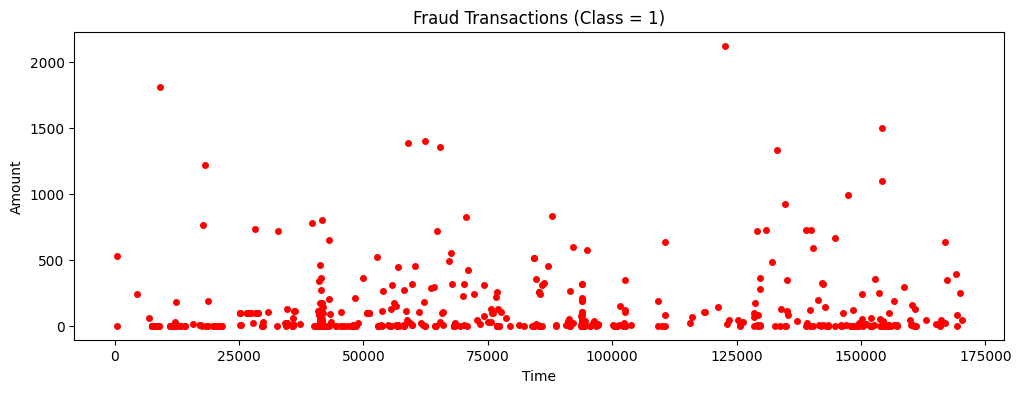

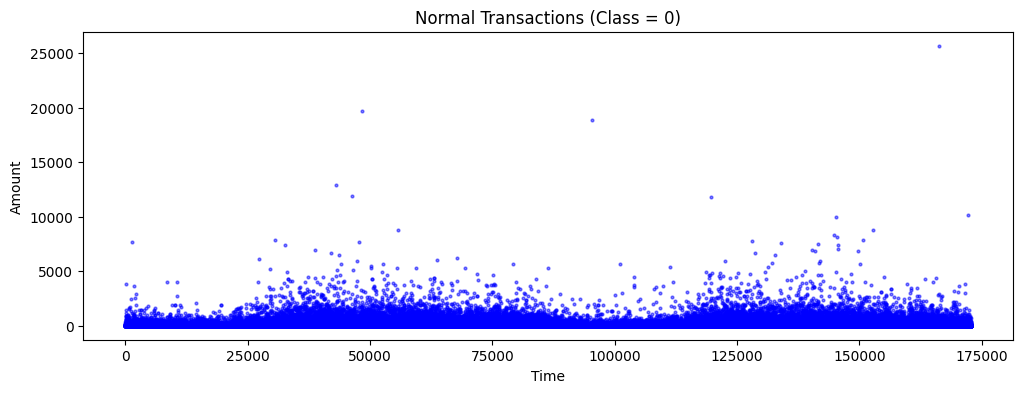

In [29]:
# Full Data Plot
plt.figure(figsize=(12, 4))
plt.plot(df['Time'], df['Amount'])
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('All Credit Transactions')
plt.show()

# Fraud Transactions (Class = 1)
plt.figure(figsize=(12, 4))
fraud_data = df[(df['Class'] == 1)]
plt.plot(fraud_data['Time'], fraud_data['Amount'], 'ro', markersize=4)  # Red circles
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Fraud Transactions (Class = 1)')
plt.show()

# Normal Transactions (Class = 0)
plt.figure(figsize=(12, 4))
normal_data = df[(df['Class'] == 0)]
plt.plot(normal_data['Time'], normal_data['Amount'], 'bo', alpha=0.5, markersize=2)  # Blue circles
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Normal Transactions (Class = 0)')
plt.show()


## Step 2. Data Cleaning
* Handle missing values if present (verify first).
* Detect and remove duplicate transactions.

In [30]:
print(f"\nNumber of Null Value rows: {df.isnull().sum()}")
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of Null Value rows: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Number of duplicate rows: 1081


In [31]:
# Remove duplicated values
duplicate_rows = df[df.duplicated(keep=False)] # `keep=False` marks all duplicates
print(f"Number of duplicate rows (including originals): {len(duplicate_rows)}")
print(duplicate_rows.sort_values(by=['Time', 'Amount']).head(10)) # Sort to see patterns

# Handle Duplicates
print(f"Duplicates before cleaning: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Duplicates after cleaning: {df.duplicated().sum()}")

# Final check
print("\nFinal Dataset Shape:", df.shape)
print("\nMissing Values after cleaning:")
print(df.isnull().sum().sum()) # Should be 0

Number of duplicate rows (including originals): 1854
      Time        V1        V2        V3        V4        V5        V6  \
34    26.0 -0.535388  0.865268  1.351076  0.147575  0.433680  0.086983   
35    26.0 -0.535388  0.865268  1.351076  0.147575  0.433680  0.086983   
32    26.0 -0.529912  0.873892  1.347247  0.145457  0.414209  0.100223   
33    26.0 -0.529912  0.873892  1.347247  0.145457  0.414209  0.100223   
112   74.0  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   
113   74.0  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   
114   74.0  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   
115   74.0  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   
220  145.0 -2.420413  1.947885  0.553646  0.983069 -0.281518  2.408958   
221  145.0 -2.420413  1.947885  0.553646  0.983069 -0.281518  2.408958   

           V7        V8        V9  ...       V21       V22       V23  \
34   0.693039  0.179742 -0.285642  ...  0.049526  0.206537 -

## Step 3. Feature Transformation
* Apply log transformation to Amount to reduce skewness.
* Scale Time and Amount using StandardScaler.

   Time  Time_scaled  Amount  Amount_log  Amount_log_scaled
0   0.0    -1.996823  149.62    5.014760           1.123062
1   0.0    -1.996823    2.69    1.305626          -1.115298
2   1.0    -1.996802  378.66    5.939276           1.680981
3   1.0    -1.996802  123.50    4.824306           1.008128
4   2.0    -1.996781   69.99    4.262539           0.669117

Final Skewness - Amount_log: 0.1614


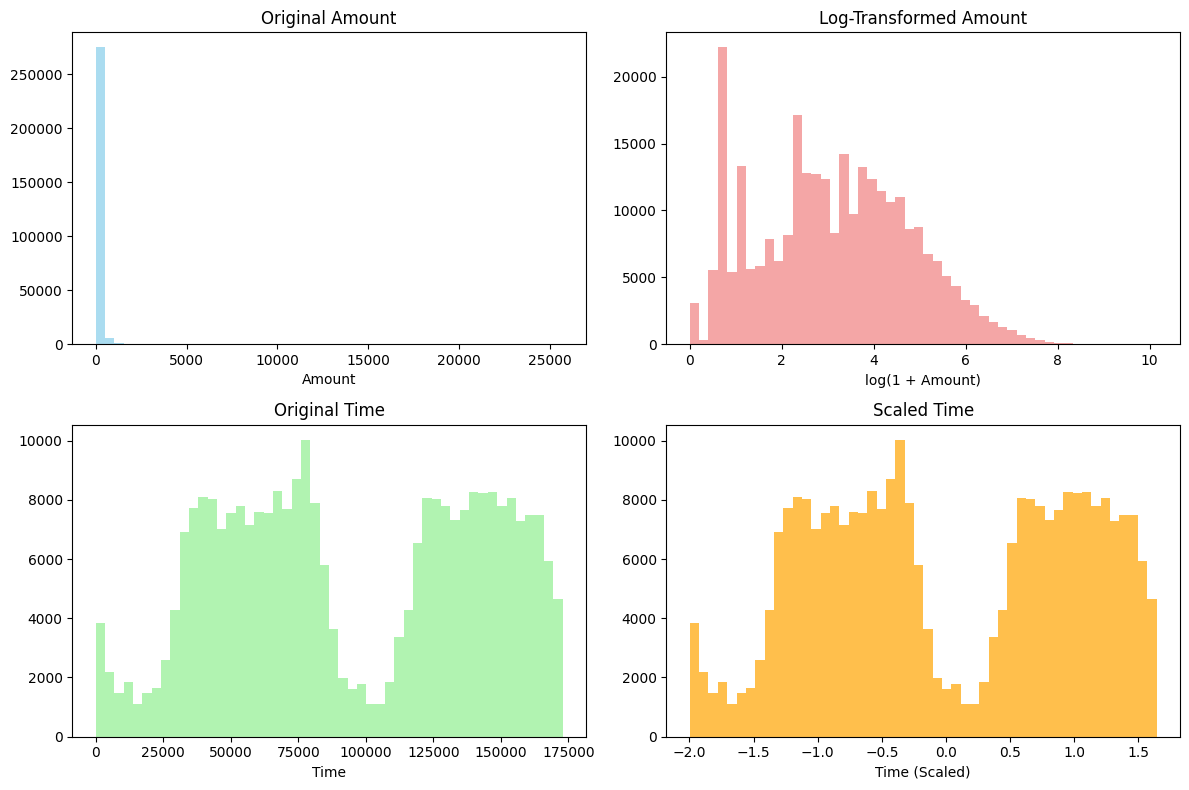


Scaled Features Summary:
Time_scaled - Mean: 0.000000, Std: 1.000002
Amount_log_scaled - Mean: 0.000000, Std: 1.000002


In [32]:
df['Amount_log'] = np.log1p(df['Amount'])
scaler = StandardScaler()
scale_columns = ['Time', 'Amount_log']
df[['Time_scaled', 'Amount_log_scaled']] = scaler.fit_transform(df[scale_columns])

# Show final result
print(df[['Time', 'Time_scaled', 'Amount', 'Amount_log', 'Amount_log_scaled']].head())
print(f"\nFinal Skewness - Amount_log: {df['Amount_log'].skew():.4f}")

# Create side-by-side comparison plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original vs Log Amount
axes[0, 0].hist(df['Amount'], bins=50, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Original Amount')
axes[0, 0].set_xlabel('Amount')

axes[0, 1].hist(df['Amount_log'], bins=50, color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Log-Transformed Amount')
axes[0, 1].set_xlabel('log(1 + Amount)')

# Original vs Scaled Time
axes[1, 0].hist(df['Time'], bins=50, color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Original Time')
axes[1, 0].set_xlabel('Time')

axes[1, 1].hist(df['Time_scaled'], bins=50, color='orange', alpha=0.7)
axes[1, 1].set_title('Scaled Time')
axes[1, 1].set_xlabel('Time (Scaled)')

plt.tight_layout()
plt.show()

# Additional summary
print(f"\nScaled Features Summary:")
print(f"Time_scaled - Mean: {df['Time_scaled'].mean():.6f}, Std: {df['Time_scaled'].std():.6f}")
print(f"Amount_log_scaled - Mean: {df['Amount_log_scaled'].mean():.6f}, Std: {df['Amount_log_scaled'].std():.6f}")

## Step 4: Handling Class Imbalance
* Use SMOTE (Synthetic Minority Oversampling Technique) to balance fraud vs.
normal cases.
* Compare class distributions before and after SMOTE.

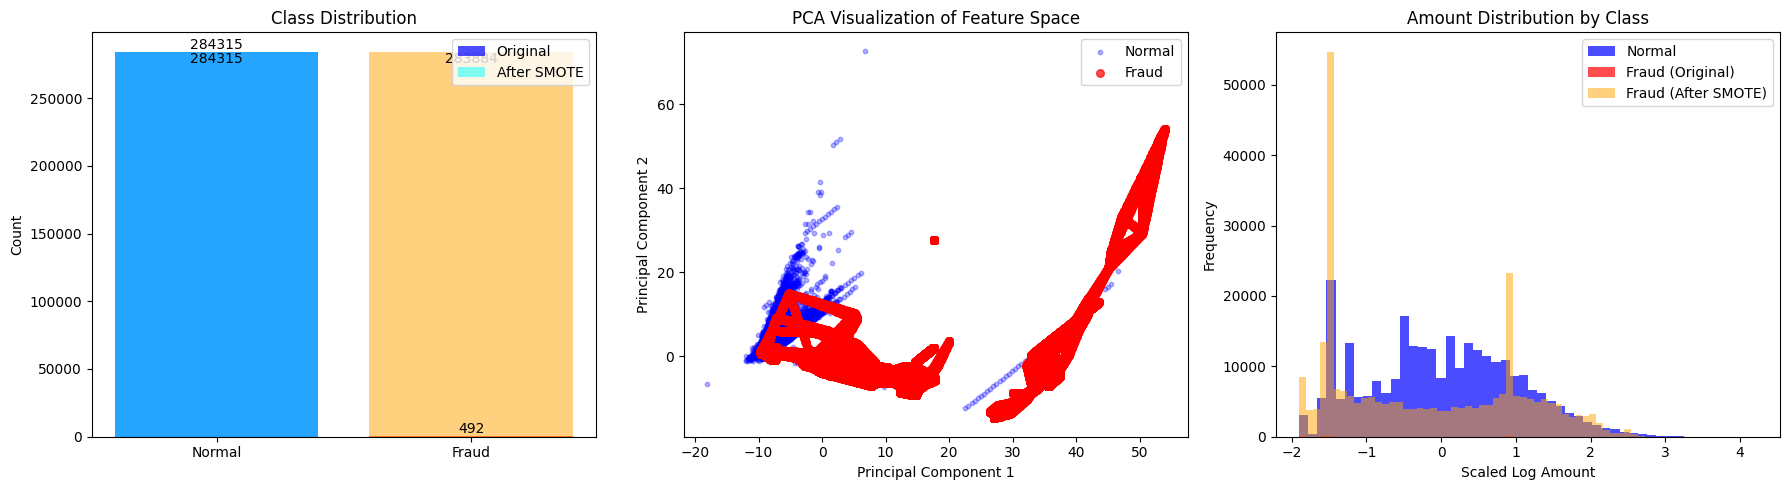

Original dataset: 284807 samples, 492 fraud cases (0.17%)
After SMOTE: 568199 samples, 283884 fraud cases (49.96%)


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Load and preprocess data
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df['Amount_log'] = np.log1p(df['Amount'])
df['Time_scaled'] = (df['Time'] - df['Time'].mean()) / df['Time'].std()
df['Amount_log_scaled'] = (df['Amount_log'] - df['Amount_log'].mean()) / df['Amount_log'].std()

# Prepare features and target
X = df.drop(['Class', 'Time', 'Amount', 'Amount_log'], axis=1)
y = df['Class']

# Manual SMOTE implementation
def manual_smote(X, y, minority_class=1, k=5, sampling_ratio=1.0):
    # Convert to numpy arrays for easier manipulation
    X_np = X.values
    y_np = y.values
    
    # Separate classes
    minority_mask = (y_np == minority_class)
    X_minority = X_np[minority_mask]
    X_majority = X_np[~minority_mask]
    y_majority = y_np[~minority_mask]
    
    # Calculate number of synthetic samples
    n_minority = len(X_minority)
    n_majority = len(X_majority)
    n_synthetic = int((n_majority - n_minority) * sampling_ratio)
    
    # Find k-nearest neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X_minority)
    
    # Generate synthetic samples
    synthetic_samples = []
    for i in range(n_minority):
        _, indices = knn.kneighbors(X_minority[i].reshape(1, -1), n_neighbors=k+1)
        neighbors = indices[0][1:]  # Remove the point itself
        
        for _ in range(n_synthetic // n_minority):
            neighbor_idx = np.random.choice(neighbors)
            diff = X_minority[neighbor_idx] - X_minority[i]
            synthetic = X_minority[i] + np.random.random() * diff
            synthetic_samples.append(synthetic)
    
    # Combine all samples
    X_resampled = np.vstack([X_np, np.array(synthetic_samples)])
    y_resampled = np.concatenate([y_np, np.full(len(synthetic_samples), minority_class)])
    
    # Shuffle
    shuffle_idx = np.random.permutation(len(X_resampled))
    return X_resampled[shuffle_idx], y_resampled[shuffle_idx]

# Apply SMOTE
X_resampled, y_resampled = manual_smote(X, y)

# Get the index of the Amount_log_scaled column
amount_col_idx = X.columns.get_loc('Amount_log_scaled')

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. Class distribution comparison
counts_before = np.bincount(y)
counts_after = np.bincount(y_resampled)
ax1.bar(['Normal', 'Fraud'], counts_before, color=['blue', 'red'], alpha=0.7, label='Original')
ax1.bar(['Normal', 'Fraud'], counts_after, color=['cyan', 'orange'], alpha=0.5, label='After SMOTE')
ax1.set_title('Class Distribution')
ax1.set_ylabel('Count')
ax1.legend()
ax1.text(0, counts_before[0], str(counts_before[0]), ha='center', va='bottom')
ax1.text(1, counts_before[1], str(counts_before[1]), ha='center', va='bottom')
ax1.text(0, counts_after[0], str(counts_after[0]), ha='center', va='top')
ax1.text(1, counts_after[1], str(counts_after[1]), ha='center', va='top')

# 2. PCA visualization of feature space
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plot original points
normal_mask = (y_resampled == 0)
fraud_mask = (y_resampled == 1)
ax2.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
           alpha=0.3, c='blue', s=10, label='Normal')
ax2.scatter(X_pca[fraud_mask, 0], X_pca[fraud_mask, 1], 
           alpha=0.7, c='red', s=30, label='Fraud')
ax2.set_title('PCA Visualization of Feature Space')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.legend()

# 3. Amount distribution comparison - FIXED
# Get the original and resampled amount values
original_normal_amounts = X[y == 0].iloc[:, amount_col_idx].values
original_fraud_amounts = X[y == 1].iloc[:, amount_col_idx].values
resampled_fraud_amounts = X_resampled[fraud_mask, amount_col_idx]

ax3.hist(original_normal_amounts, bins=50, alpha=0.7, color='blue', label='Normal')
ax3.hist(original_fraud_amounts, bins=50, alpha=0.7, color='red', label='Fraud (Original)')
ax3.hist(resampled_fraud_amounts, bins=50, alpha=0.5, color='orange', label='Fraud (After SMOTE)')
ax3.set_title('Amount Distribution by Class')
ax3.set_xlabel('Scaled Log Amount')
ax3.set_ylabel('Frequency')
ax3.legend()

plt.tight_layout()
plt.show()

# Print summary
print(f"Original dataset: {X.shape[0]} samples, {counts_before[1]} fraud cases ({counts_before[1]/counts_before.sum()*100:.2f}%)")
print(f"After SMOTE: {X_resampled.shape[0]} samples, {counts_after[1]} fraud cases ({counts_after[1]/counts_after.sum()*100:.2f}%)")

## Step 5: Feature Engineering
* Create a new feature TransactionHour = Time // 3600.
* Create Amount_per_Time = Amount / (Time+1).
* Discretize Amount into bins (Low, Medium, High).

In [24]:
# 1. TransactionHour = Time // 3600
df['TransactionHour'] = df['Time'] // 3600

# 2. Amount_per_Time = Amount / (Time+1)   (avoid division by zero)
df['Amount_per_Time'] = df['Amount'] / (df['Time'] + 1)

# 3. Discretize Amount into bins (Low, Medium, High)
df['Amount_Bin'] = pd.cut(
    df['Amount'],
    bins=[-1, 50, 200, df['Amount'].max()],   # simple thresholds
    labels=['Low', 'Medium', 'High']
)

# Preview new features
print(df[['Amount', 'Time', 'TransactionHour', 'Amount_per_Time', 'Amount_Bin']])

        Amount      Time  TransactionHour  Amount_per_Time Amount_Bin
0       149.62       0.0              0.0       149.620000     Medium
1         2.69       0.0              0.0         2.690000        Low
2       378.66       1.0              0.0       189.330000       High
3       123.50       1.0              0.0        61.750000     Medium
4        69.99       2.0              0.0        23.330000     Medium
...        ...       ...              ...              ...        ...
284802    0.77  172786.0             47.0         0.000004        Low
284803   24.79  172787.0             47.0         0.000143        Low
284804   67.88  172788.0             47.0         0.000393     Medium
284805   10.00  172788.0             47.0         0.000058        Low
284806  217.00  172792.0             47.0         0.001256       High

[283726 rows x 5 columns]


## Step 6: Outlier Detection (Statistical)
* Use IQR (Interquartile Range method) to detect extreme outliers in Amount and Time.
* Define outliers as values below Q1 – 1.5×IQR or above Q3 + 1.5×IQR.
* Alternatively, use Z-score method (|z| > 3) to flag outliers in continuous variables.
* Decide whether to cap, transform, or remove these outliers and justify your choice.

In [36]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

outliers_amount_iqr = detect_outliers_iqr(df['Amount'])
outliers_time_iqr   = detect_outliers_iqr(df['Time'])

print("IQR Outliers in Amount:", len(outliers_amount_iqr))
print("IQR Outliers in Time:", len(outliers_time_iqr))

# -------------------
# Z-Score Method
# -------------------
z_scores_amount = np.abs(stats.zscore(df['Amount']))
z_scores_time   = np.abs(stats.zscore(df['Time']))

outliers_amount_z = df['Amount'][z_scores_amount > 3]
outliers_time_z   = df['Time'][z_scores_time > 3]

print("Z-Score Outliers in Amount:", len(outliers_amount_z))
print("Z-Score Outliers in Time:", len(outliers_time_z))

# -------------------
# Handling Choice
# -------------------
# For fraud detection:
# - Amount outliers are often meaningful (big fraud transactions).
# - Time outliers may reflect system/recording issues.
# Strategy: cap extreme values instead of removing
df['Amount_capped'] = np.where(
    df['Amount'] > outliers_amount_iqr.max(), outliers_amount_iqr.max(), df['Amount']
)

df['Time_capped'] = np.where(
    df['Time'] > outliers_time_iqr.max(), outliers_time_iqr.max(), df['Time']
)

print(df[['Amount','Amount_capped','Time','Time_capped']].head())

IQR Outliers in Amount: 31904
IQR Outliers in Time: 0
Z-Score Outliers in Amount: 4076
Z-Score Outliers in Time: 0
   Amount  Amount_capped  Time  Time_capped
0  149.62         149.62   0.0          0.0
1    2.69           2.69   0.0          0.0
2  378.66         378.66   1.0          1.0
3  123.50         123.50   1.0          1.0
4   69.99          69.99   2.0          2.0


## Step 7: Correlation & Heatmaps
* Plot a correlation matrix heatmap of all numerical features.
* Identify highly correlated features and discuss whether to drop or keep them.

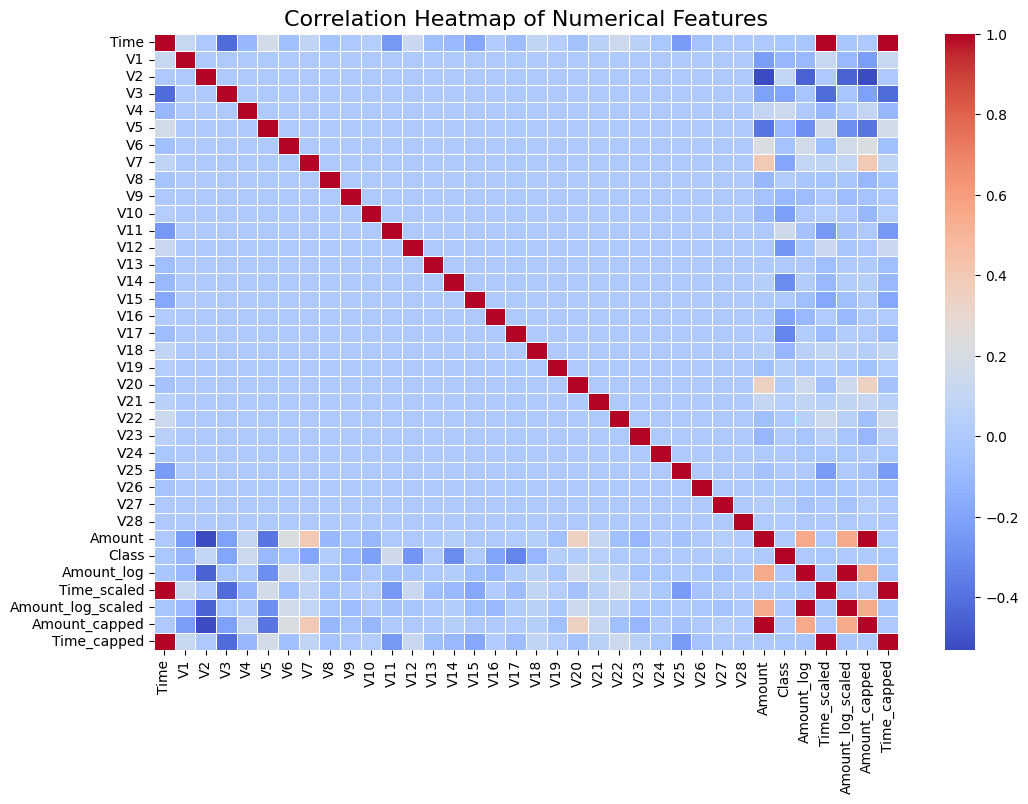

Highly correlated features (|corr| > 0.8):
                level_0            level_1  correlation
32                 Time        Time_scaled          1.0
35                 Time        Time_capped          1.0
1078             Amount      Amount_capped          1.0
1149         Amount_log  Amount_log_scaled          1.0
1152        Time_scaled               Time          1.0
1187        Time_scaled        Time_capped          1.0
1219  Amount_log_scaled         Amount_log          1.0
1253      Amount_capped             Amount          1.0
1260        Time_capped               Time          1.0
1292        Time_capped        Time_scaled          1.0


In [37]:
# Compute correlation matrix and drop NaN correlations
corr_matrix = df.corr(numeric_only=True).fillna(0)

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

# Handle highly correlated features (abs(corr) > 0.8)
threshold = 0.8
high_corr = (
    corr_matrix
    .stack()
    .reset_index()
    .rename(columns={0: "correlation"})
)
high_corr = high_corr[
    (high_corr['correlation'].abs() > threshold) & 
    (high_corr['level_0'] != high_corr['level_1'])
]

print("Highly correlated features (|corr| > 0.8):")
print(high_corr)

____

# Section 2: Computer Vision

### This section explores the world of Computer Vision using the [Chest X-Ray (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. Using Pillow, OpenCV and Scikit-Image to converse and manipulate the contents of the dataset to explore various ML techniques within Computer Vision

In [46]:
# SETUP BASE CONFIG

import os
import cv2                  # OpenCV
import numpy as np
from PIL import Image       # Pillow
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("Available datasets:", os.listdir("/kaggle/input"))


DATA_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "val")
test_dir  = os.path.join(DATA_DIR, "test")

print("Train folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(val_dir))
print("Test folders:", os.listdir(test_dir))

categories = ["NORMAL", "PNEUMONIA"]

Available datasets: ['chest-xray-pneumonia']
Train folders: ['PNEUMONIA', 'NORMAL']
Validation folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


## Question 1: Image Loading and Conversion

* Load the Dataset and visualize a few datasamples
* Convert Imaged to GrayScale using both *OpenCV* and *Pillow*

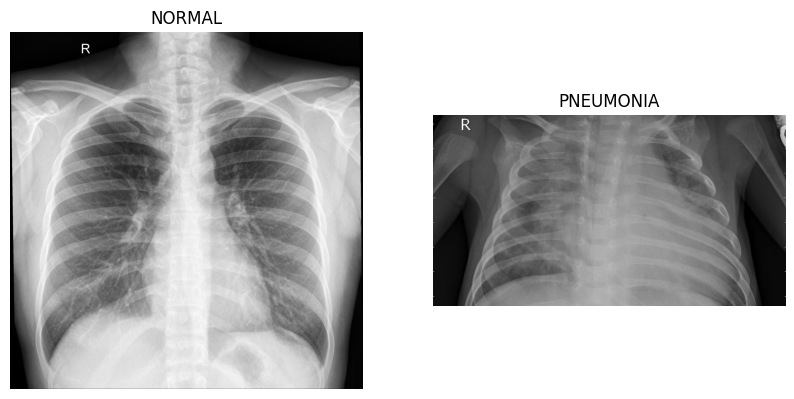

Sample image: /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0502-0001.jpeg


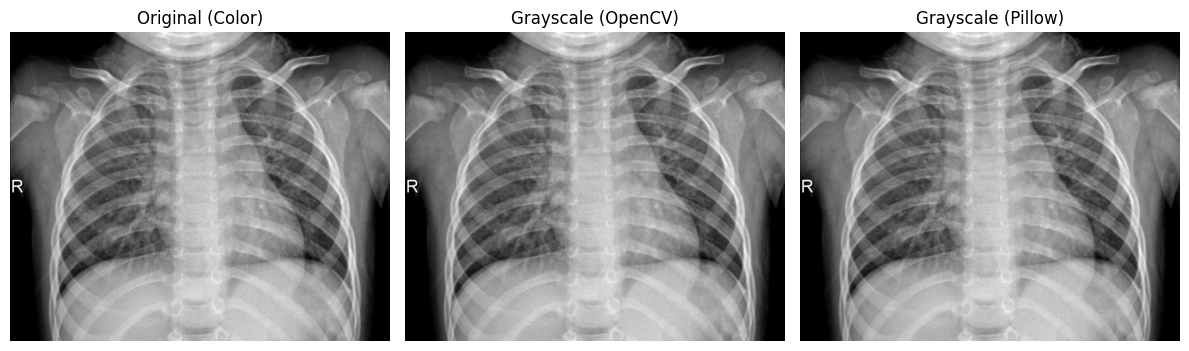

In [47]:
#TASK 1

plt.figure(figsize=(10, 6))

for i, category in enumerate(categories):
    folder = os.path.join(train_dir, category)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    
    # Load image for random viewing
    img = cv2.imread(img_path)
    
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(category)
    plt.axis("off")

plt.show()


# Pick a random category and image
category = random.choice(categories)
folder = os.path.join(train_dir, category)
img_name = random.choice(os.listdir(folder))
img_path = os.path.join(folder, img_name)

print(f"Sample image: {img_path}")

# OpenCV grayscale
img_cv = cv2.imread(img_path)                         # BGR 
gray_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)    # Grayscale Conversion

# Pillow grayscale
img_pil = Image.open(img_path)        # Load - Pillow
gray_pil = img_pil.convert("L")       # Convert to grayscale ("L" mode)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))  # Convert BGR→RGB for matplotlib
plt.title("Original (Color)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gray_cv, cmap="gray")
plt.title("Grayscale (OpenCV)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gray_pil, cmap="gray")
plt.title("Grayscale (Pillow)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Question 2: Resizing and Cropping

* Resize all images to 128 × 128.
* Randomly crop a 100×100 region from some images and compare with resized versions.

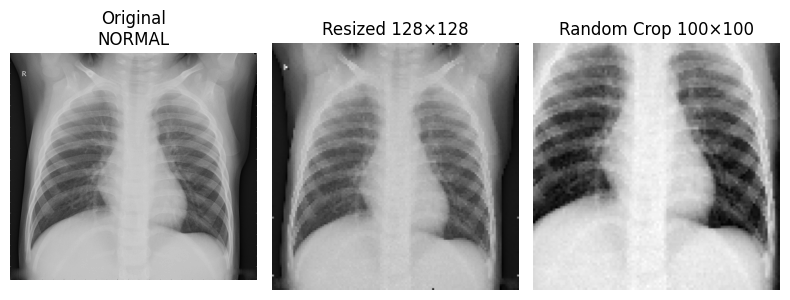

In [48]:
#TASK 2

# Pick random image
category = random.choice(categories)
folder = os.path.join(train_dir, category)
img_path = os.path.join(folder, random.choice(os.listdir(folder)))

# Load and resize to 128x128
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
resized = cv2.resize(img, (128, 128))

# Random crop 100x100
x = random.randint(0, resized.shape[1] - 100)
y = random.randint(0, resized.shape[0] - 100)
cropped = resized[y:y+100, x:x+100]

# Plot results
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title(f"Original\n{category}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(resized, cmap="gray")
plt.title("Resized 128×128")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cropped, cmap="gray")
plt.title("Random Crop 100×100")
plt.axis("off")

plt.tight_layout()
plt.show()


## Question 3: Color Space Conversions

* Convert dataset images into HSV and LAB color spaces.
* Display original vs converted images for at least 5 samples.

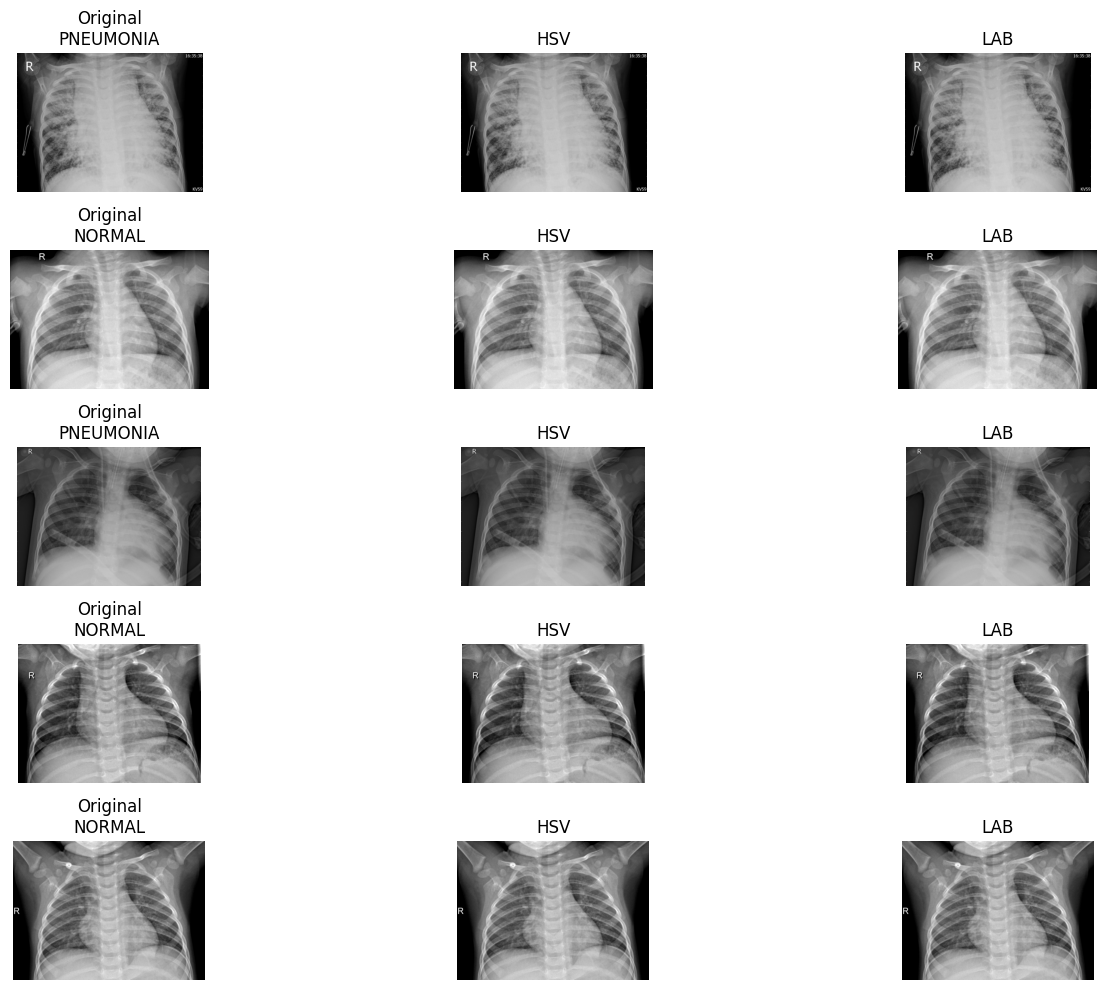

In [49]:
#TASK 3

# Show 5 random samples
plt.figure(figsize=(15, 10))

for i in range(5):
    category = random.choice(categories)
    folder = os.path.join(train_dir, category)
    img_path = os.path.join(folder, random.choice(os.listdir(folder)))
    
    # Load original image (as color)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR -> RGB for matplotlib

    # Convert to HSV and LAB
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Plot side by side
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(img_rgb)
    plt.title(f"Original\n{category}")
    plt.axis("off")

    plt.subplot(5, 3, 3*i+2)
    plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))  # convert for display
    plt.title("HSV")
    plt.axis("off")

    plt.subplot(5, 3, 3*i+3)
    plt.imshow(cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB))  # convert for display
    plt.title("LAB")
    plt.axis("off")

plt.tight_layout()
plt.show()



## Question 4: Normalization and Histogram Equalization
* Normalize pixel values of all images to the range [0, 1].
* Apply histogram equalization to grayscale images and show improvements in
contrast.

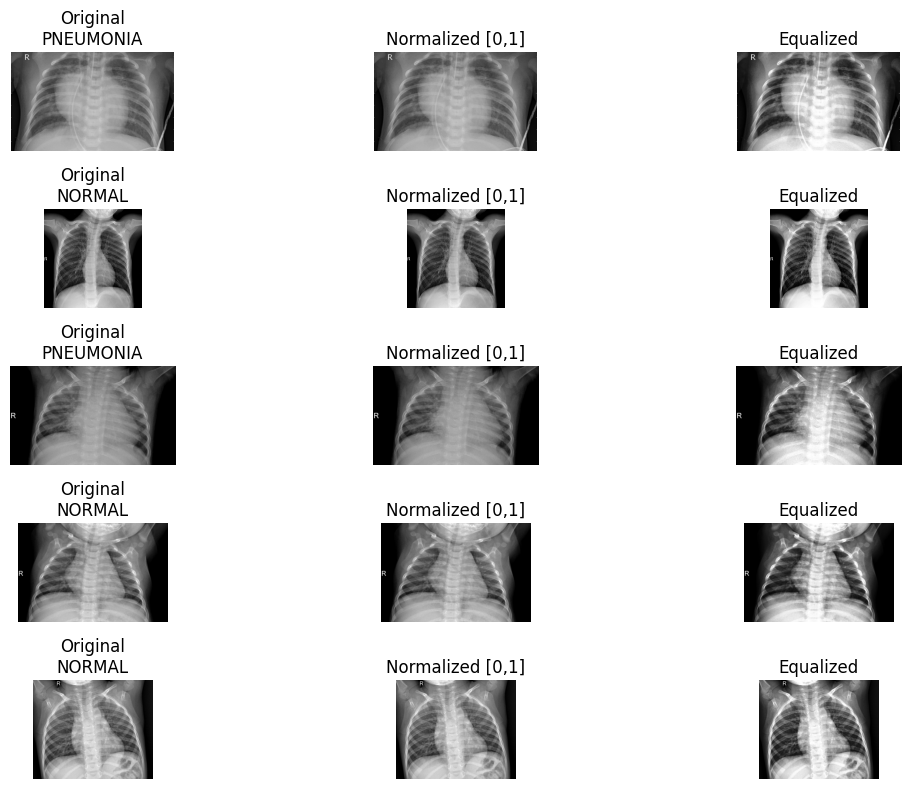

In [61]:
# Task 4

# Pick 5 random grayscale images
plt.figure(figsize=(12, 8))

for i in range(5):
    category = random.choice(categories)
    folder = os.path.join(train_dir, category)
    img_path = os.path.join(folder, random.choice(os.listdir(folder)))
    
    # Load grayscale
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # 1. Normalize to [0, 1]
    img_norm = img_gray / 255.0
    
    # 2. Histogram Equalization
    img_eq = cv2.equalizeHist(img_gray)
    
    # Plot
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(img_gray, cmap="gray")
    plt.title(f"Original\n{category}")
    plt.axis("off")

    plt.subplot(5, 3, 3*i+2)
    plt.imshow(img_norm, cmap="gray")
    plt.title("Normalized [0,1]")
    plt.axis("off")

    plt.subplot(5, 3, 3*i+3)
    plt.imshow(img_eq, cmap="gray")
    plt.title("Equalized")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Question 5. Noise Injection and Denoising
* Add synthetic noise to images using different distributions:
    - (a) Gaussian noise
    - (b) Salt-and-pepper noise
    - (c) Uniform noise
* Apply Gaussian Blur, Median Blur, and Bilateral Filtering to denoise.
* Compare original, noisy, and denoised outputs.

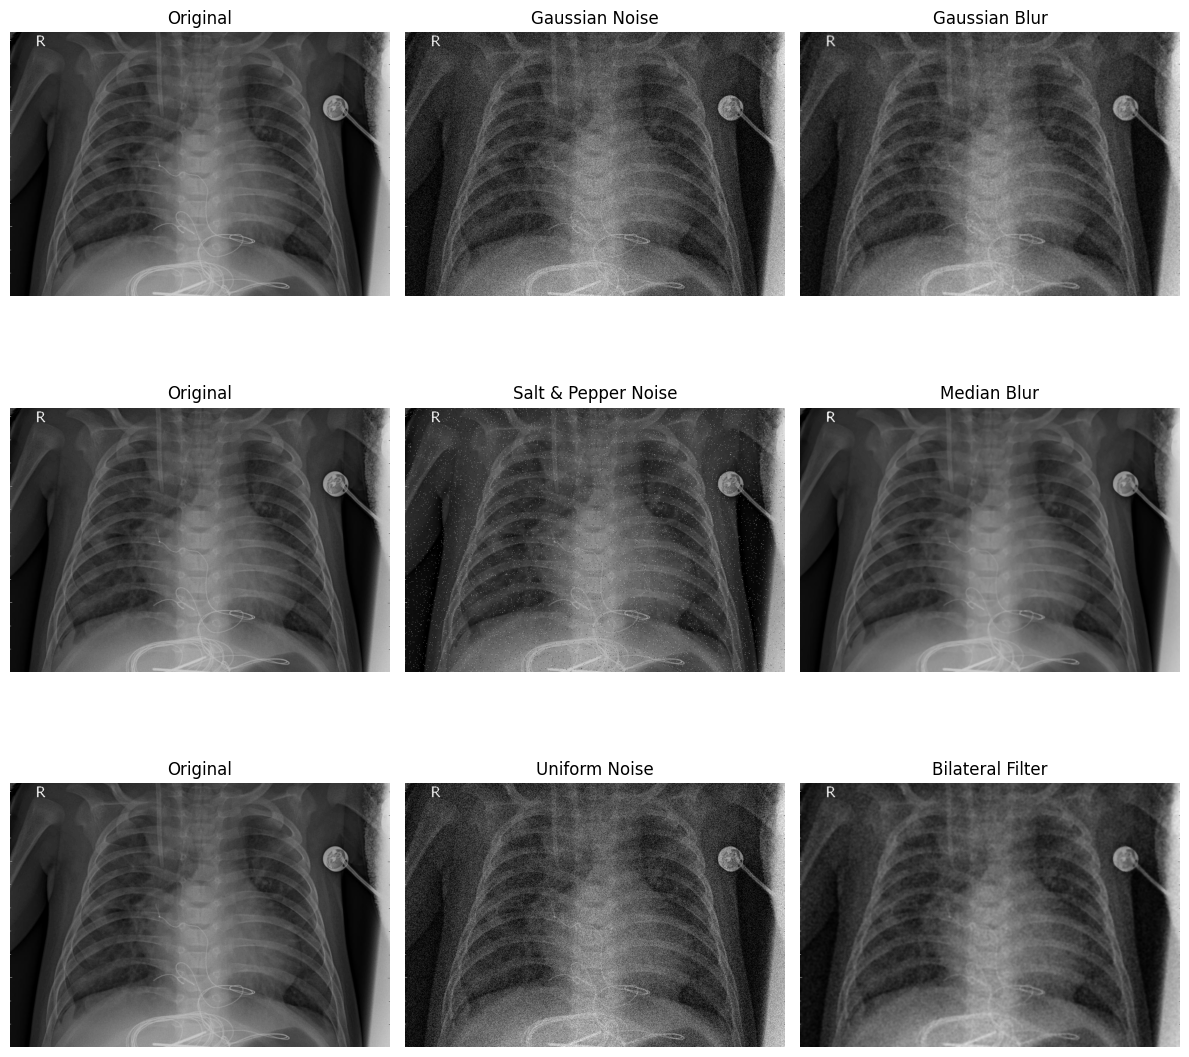

In [53]:
# ✅ Task 5: Noise Injection and Denoising
img = cv2.imread(sample_paths[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ---- Noise Functions ----
def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(image, amount=0.02):
    noisy = image.copy()
    num_salt = np.ceil(amount * image.size * 0.5).astype(int)
    num_pepper = np.ceil(amount * image.size * 0.5).astype(int)
    
    # Salt noise
    coords = (np.random.randint(0, image.shape[0], num_salt),
              np.random.randint(0, image.shape[1], num_salt))
    noisy[coords] = 255
    
    # Pepper noise
    coords = (np.random.randint(0, image.shape[0], num_pepper),
              np.random.randint(0, image.shape[1], num_pepper))
    noisy[coords] = 0
    
    return noisy

def add_uniform_noise(image, low=-50, high=50):
    noise = np.random.uniform(low, high, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

# ---- Apply Noises ----
gaussian_noisy = add_gaussian_noise(gray)
sp_noisy = add_salt_pepper_noise(gray)
uniform_noisy = add_uniform_noise(gray)

# ---- Apply Denoising ----
gaussian_denoised = cv2.GaussianBlur(gaussian_noisy, (5,5), 0)
sp_denoised = cv2.medianBlur(sp_noisy, 5)
uniform_denoised = cv2.bilateralFilter(uniform_noisy, 9, 75, 75)

# ---- Visualization ----
fig, axs = plt.subplots(3,3, figsize=(12,12))

axs[0,0].imshow(gray, cmap="gray"); axs[0,0].set_title("Original"); axs[0,0].axis("off")
axs[0,1].imshow(gaussian_noisy, cmap="gray"); axs[0,1].set_title("Gaussian Noise"); axs[0,1].axis("off")
axs[0,2].imshow(gaussian_denoised, cmap="gray"); axs[0,2].set_title("Gaussian Blur"); axs[0,2].axis("off")

axs[1,0].imshow(gray, cmap="gray"); axs[1,0].set_title("Original"); axs[1,0].axis("off")
axs[1,1].imshow(sp_noisy, cmap="gray"); axs[1,1].set_title("Salt & Pepper Noise"); axs[1,1].axis("off")
axs[1,2].imshow(sp_denoised, cmap="gray"); axs[1,2].set_title("Median Blur"); axs[1,2].axis("off")

axs[2,0].imshow(gray, cmap="gray"); axs[2,0].set_title("Original"); axs[2,0].axis("off")
axs[2,1].imshow(uniform_noisy, cmap="gray"); axs[2,1].set_title("Uniform Noise"); axs[2,1].axis("off")
axs[2,2].imshow(uniform_denoised, cmap="gray"); axs[2,2].set_title("Bilateral Filter"); axs[2,2].axis("off")

plt.tight_layout()
plt.show()


## Question 6. Image Rotation
* Rotate dataset images by 45◦, 90◦, and 180◦ and save results.

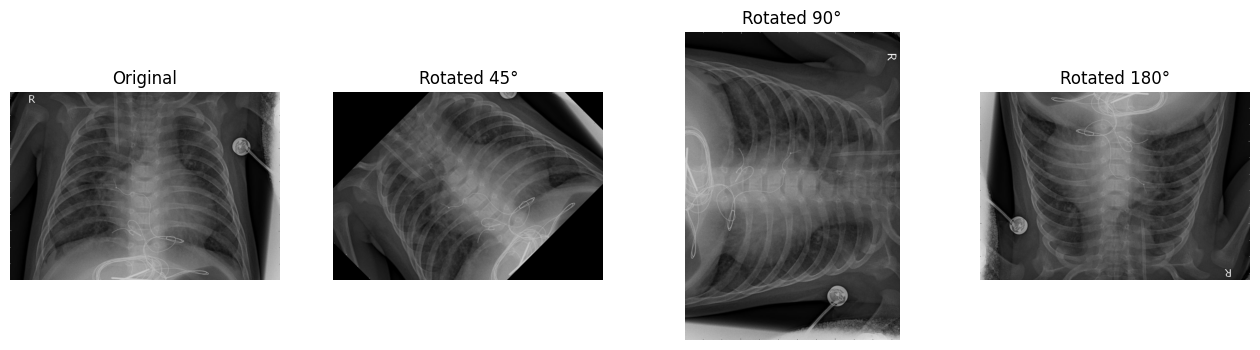

In [54]:
# Task 6

img = cv2.imread(sample_paths[0])
(h , w ) = img . shape [:2]
center = ( w // 2 , h // 2)
M = cv2.getRotationMatrix2D ( center, 45, 1.0)


rot45 = cv2.warpAffine(img, M, (w, h))
rot90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
rot180 = cv2.rotate(img, cv2.ROTATE_180)

fig, axs = plt.subplots(1,4, figsize=(16,4))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); axs[0].set_title("Original"); axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(rot45, cv2.COLOR_BGR2RGB)); axs[1].set_title("Rotated 45°"); axs[1].axis("off")
axs[2].imshow(cv2.cvtColor(rot90, cv2.COLOR_BGR2RGB)); axs[2].set_title("Rotated 90°"); axs[2].axis("off")
axs[3].imshow(cv2.cvtColor(rot180, cv2.COLOR_BGR2RGB)); axs[3].set_title("Rotated 180°"); axs[3].axis("off")
plt.show()


## Question 7. Morphological Operations
* Apply erosion, dilation, opening, and closing to binary versions of selected
images.
* Display results in a 2 × 2 grid.

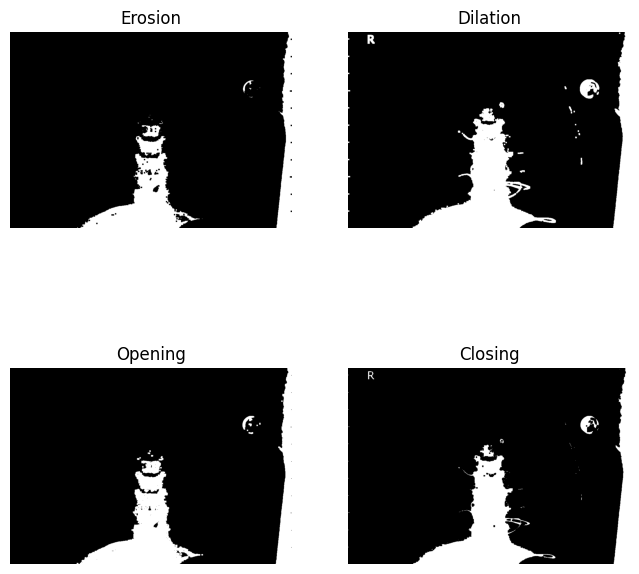

In [55]:
# Task 7

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
kernel = np.ones((5,5), np.uint8)

erosion = cv2.erode(binary, kernel, iterations=1)
dilation = cv2.dilate(binary, kernel, iterations=1)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

titles = ["Erosion","Dilation","Opening","Closing"]
images = [erosion,dilation,opening,closing]

plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1); plt.imshow(images[i], cmap="gray"); plt.title(titles[i]); plt.axis("off")
plt.show()


## Question 8. Background Removal and Edge Detection
* Use binary thresholding and Canny edge detection on selected dataset images.
* Compare which method gives better edge boundaries.

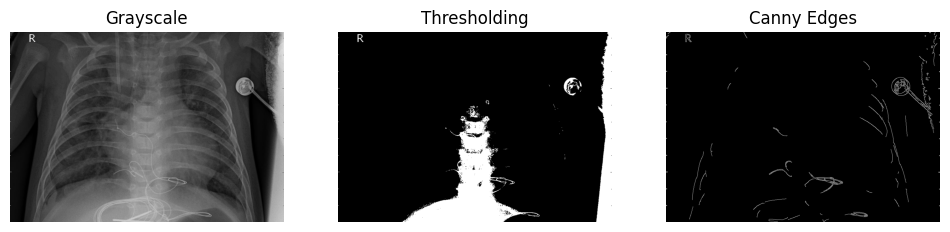

In [56]:
# Task 8

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(gray, 100, 200)

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(gray, cmap="gray"); axs[0].set_title("Grayscale"); axs[0].axis("off")
axs[1].imshow(thresh, cmap="gray"); axs[1].set_title("Thresholding"); axs[1].axis("off")
axs[2].imshow(edges, cmap="gray"); axs[2].set_title("Canny Edges"); axs[2].axis("off")
plt.show()

# Canny Edges give a better edge classification

## Question 9. Data Augmentation

* Use TensorFlow/Keras ImageDataGenerator to generate at least 500 aug-
mented images using rotation, shifting, flipping, and brightness change.

In [60]:
# Task 9

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import os

# Setup augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,        # random rotations
    width_shift_range=0.2,    # horizontal shifting
    height_shift_range=0.2,   # vertical shifting
    brightness_range=[0.5,1.5], # brightness variation
    horizontal_flip=True,     # random horizontal flips
    fill_mode='nearest'       # filling strategy for new pixels
)

# Directory to save augmented images
augmented_dir = "/kaggle/working/augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Pick one image from dataset (you can loop over many)
sample_img_path = os.path.join(train_dir, os.listdir(train_dir)[0], 
                               os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
img = load_img(sample_img_path)     # load image
x = img_to_array(img)               # convert to numpy
x = np.expand_dims(x, axis=0)       # reshape for generator

# Generate 500 augmented images
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=augmented_dir, save_prefix='aug', save_format='jpeg'):
    i += 1
    if i >= 500:
        break  # stop after generating 500 images

print(f"500 augmented images saved to {augmented_dir}")


500 augmented images saved to /kaggle/working/augmented


## Question 10. Complete Preprocessing Pipeline
* Write a function that:
    - (a) Loads the dataset.
    - (b) Converts to grayscale.
    - (c) Resizes to 128 × 128.
    - (d) Normalizes pixel values.
    - (e) Applies Gaussian blur.
* Apply it to the entire dataset and save the processed version.

In [ ]:
# # Task 10

# 10. Complete Preprocessing Pipeline

def preprocess_image(img_path, size=(128,128)):
    """Load image, convert to grayscale, resize, normalize, and apply Gaussian blur"""
    img = cv2.imread(img_path)                          # Load
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Grayscale
    resized = cv2.resize(gray, size)                    # Resize
    normalized = resized / 255.0                        # Normalize [0,1]
    blurred = cv2.GaussianBlur(normalized, (5,5), 0)    # Gaussian blur
    return blurred

def preprocess_dataset(data_dir, save_dir, size=(128,128)):
    """Preprocess all images in data_dir and save processed copies"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for root, _, files in os.walk(data_dir):
        rel_path = os.path.relpath(root, data_dir)
        target_path = os.path.join(save_dir, rel_path)
        os.makedirs(target_path, exist_ok=True)

        for file in files:
            if file.endswith(".jpeg") or file.endswith(".jpg") or file.endswith(".png"):
                img_path = os.path.join(root, file)
                processed = preprocess_image(img_path, size)

                # Save back as uint8
                save_path = os.path.join(target_path, file)
                cv2.imwrite(save_path, (processed*255).astype(np.uint8))

# Example usage on TRAIN dataset
processed_train_dir = "/kaggle/working/processed_train"
preprocess_dataset(train_dir, processed_train_dir)

print("Processed dataset saved at:", processed_train_dir)

### The above pipeline creates a new processed dataset within the kaggle 'working' directory